# VQ-VAE in PyTorch

## Import Libraries

In [14]:
from __future__ import print_function
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

## Install TensorBoard (for Google Colab)

Steps:
1. Uninstall all existing tensorboard and tensorflow versions.
2. Install new tensorflow and tensorboard. 
3. Restart Runtime

In [3]:
# Run this script if tensorboard fails to run because of duplicate tensorboard libraries
!pip uninstall tb-nightly tensorboard tensorflow tensorflow-estimator tensorflow-estimator-2.0-preview tf-nightly-2.0-preview -y

In [77]:
# Install working version of tensorflow with tensorboard after removing all tensorboard libraries (in previous cell)
!pip install tensorflow
!pip install tensorboard

## Load Tensorboard

In [75]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

## Set Device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Retrieve Data

Download Celeba Dataset (images and labels)

In [7]:
if not os.path.exists("ms-celeb-images-cropped-aligned.zip"):
    !wget https://maxinai-public-project-images.s3.amazonaws.com/ms-celeb-images-cropped-aligned.zip

In [8]:
if not os.path.exists("list_attr_celeba.csv"):
    !wget https://maxinai-public-project-images.s3.amazonaws.com/list_attr_celeba.csv

--2020-01-16 18:27:38--  https://maxinai-public-project-images.s3.amazonaws.com/list_attr_celeba.csv
Resolving maxinai-public-project-images.s3.amazonaws.com (maxinai-public-project-images.s3.amazonaws.com)... 52.216.86.131
Connecting to maxinai-public-project-images.s3.amazonaws.com (maxinai-public-project-images.s3.amazonaws.com)|52.216.86.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23972747 (23M) [text/csv]
Saving to: 'list_attr_celeba.csv'

list_attr_celeba.cs 100%[===================>]  22.86M  95.3MB/s    in 0.2s    

2020-01-16 18:27:39 (95.3 MB/s) - 'list_attr_celeba.csv' saved [23972747/23972747]



Unzip and prepare data

In [9]:
!unzip ms-celeb-images-cropped-aligned.zip > /dev/null

In [10]:
!mv data/ms-celeb-images-cropped-aligned/ data/celeba/

In [11]:
!mv list_attr_celeba.csv data/

## Create Dataset

In [15]:
import os
import PIL
from typing import List
from sklearn.model_selection import train_test_split

In [16]:
# defining denormalizer for normalized images.
class DeNormalize:
    
    def __init__(self, mean, std):
        
        self.mean = mean
        self.std = std

    def __call__(self, x, inplace=False):
        
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = x if inplace else x.clone() 
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        
        return tensor
   

In [7]:
class CelebFaceDataset(torch.utils.data.dataset.Dataset):
    
    def __init__(self, root_dir: str, image_ids: List[str]):
        
        self.root_dir = root_dir
        self.image_ids = image_ids
        
        self.transforms = transforms.Compose([
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*IMAGENET_STATS)
                                             ]) 
    def __getitem__(self, idx: int):
        
        im = PIL.Image.open(os.path.join(self.root_dir, self.image_ids[idx]))

        return self.transforms(im)
    
    def __len__(self):
        return len(self.image_ids)

In [8]:
def get_celeba_dls(df: pd.DataFrame, valid_size=0.01, batch_size=128):
    
    train_ids, valid_ids = train_test_split(df.image_id.tolist(), test_size=valid_size)
    
    print('Train size:', len(train_ids), 'Valid Size:', len(valid_ids))
    
    train_ds = CelebFaceDataset(DATA_DIR + '/celeba', train_ids)
    valid_ds = CelebFaceDataset(DATA_DIR + '/celeba', valid_ids)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        pin_memory=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=batch_size,
                                        shuffle=False, 
                                        pin_memory=True))

### Globals

In [9]:
IMAGENET_STATS = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# IMAGENET_STATS = [0.5]*3, [0.5]*3
DATASET_VARIANCE = 0.06158011545822623
DATA_DIR = 'data'
DATA_BATCH_SIZE = 64

### Read dataset Attributes File 

In [10]:
attr_df = pd.read_csv(DATA_DIR + '/list_attr_celeba.csv')

In [11]:
attr_df.head(2)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1


### Create Denormalizer Object
Will be used for visualizations 

In [17]:
denorm = DeNormalize(*IMAGENET_STATS)

### Get Train/Test Dataloaders

In [18]:
train_dl, valid_dl = get_celeba_dls(attr_df, batch_size=DATA_BATCH_SIZE)

Train size: 194727 Valid Size: 1967


### Show samples from Training Data

In [23]:
def show(img, **kwargs):
    np_img = img.permute(1,2,0).numpy()
    plt.figure(**kwargs)
    fig = plt.imshow(np_img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [24]:
def show_batch(batch, samples=None, **kwargs):
    if not samples:
        samples = batch.shape[0]
        
    denorm_batch = torch.stack([denorm(batch[i]) for i in range(samples)])
    batch_grid = make_grid(denorm_batch)
    show(batch_grid, **kwargs)

In [25]:
sample_batch = next(iter(train_dl))

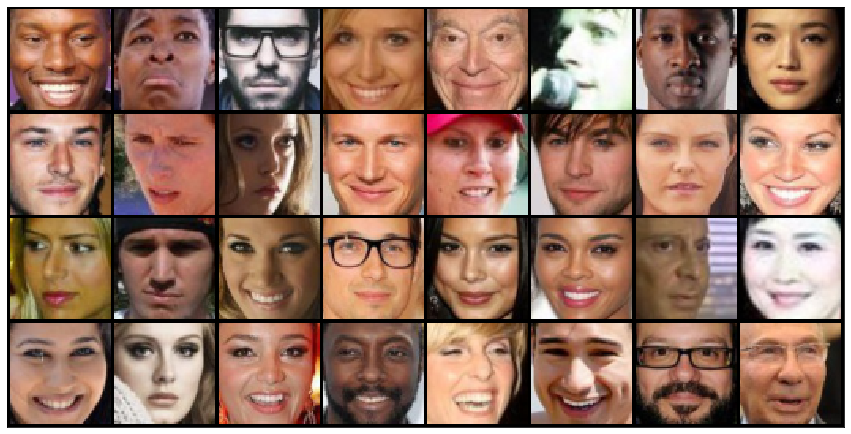

In [26]:
show_batch(sample_batch, samples=32, **{"figsize":(15, 15)})

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [27]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [28]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder is Pretrained ResNet18 and decoder is 6 layer deconvolution2d

In [50]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)

In [51]:
class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [58]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [49]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)


In [59]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
            
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

## Train

In [95]:
batch_size = 128
num_training_updates = 5000

num_hiddens = 512
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64

num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

RELU_NEG_SLOPE = 0.2

SHOW_EVERY_N_ITERATION = 200

In [96]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens, 
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [97]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

200 iterations
recon_error: 2.431
perplexity: 1.000



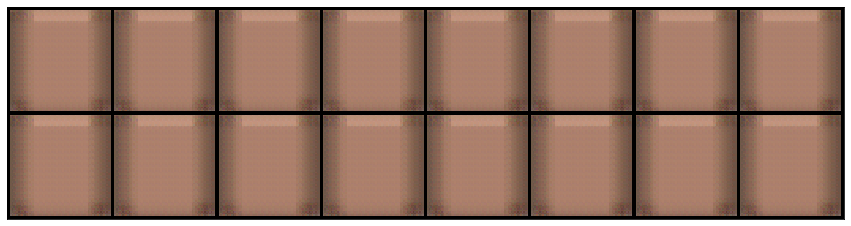

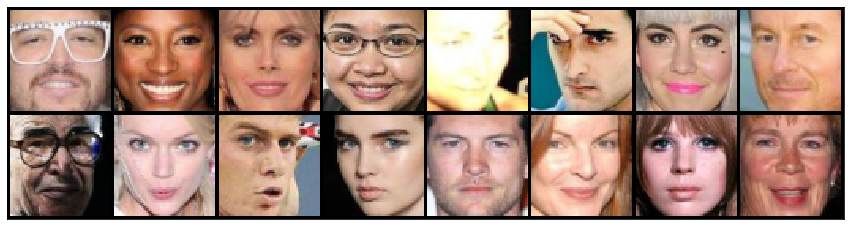

400 iterations
recon_error: 1.761
perplexity: 1.000



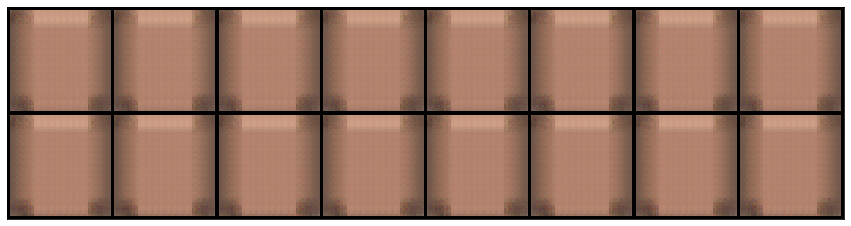

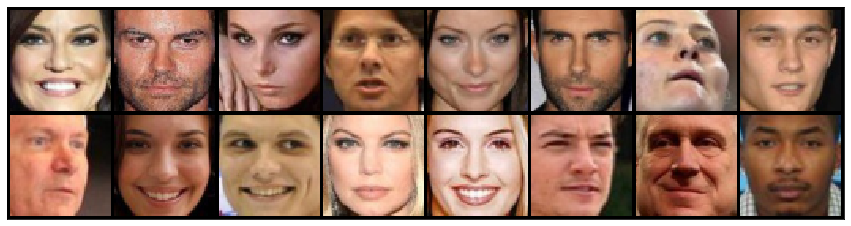

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


600 iterations
recon_error: 1.156
perplexity: 1.859



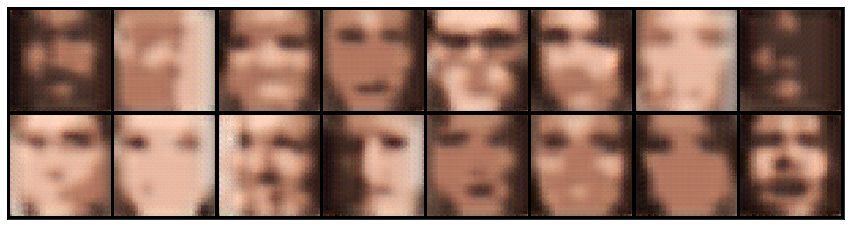

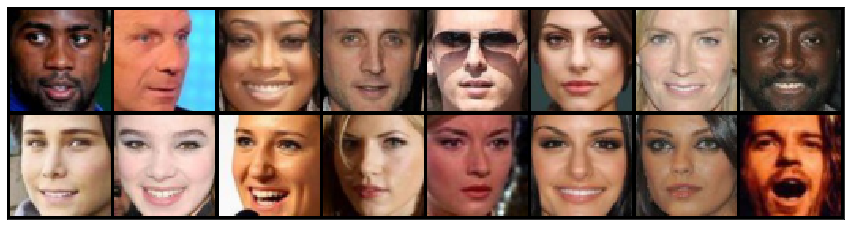

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


800 iterations
recon_error: 0.298
perplexity: 8.403



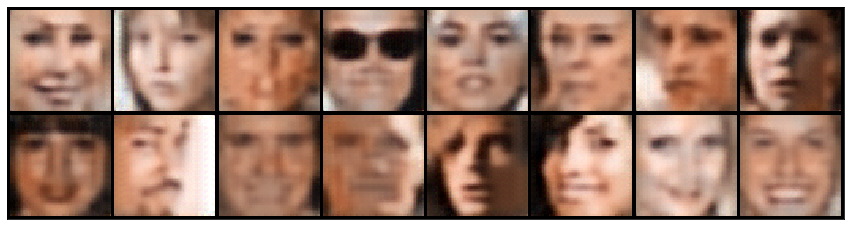

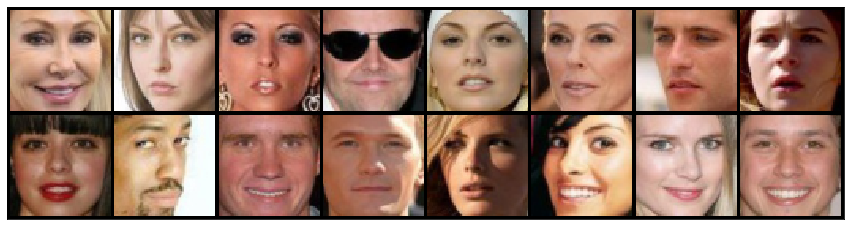

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000 iterations
recon_error: 0.178
perplexity: 20.222



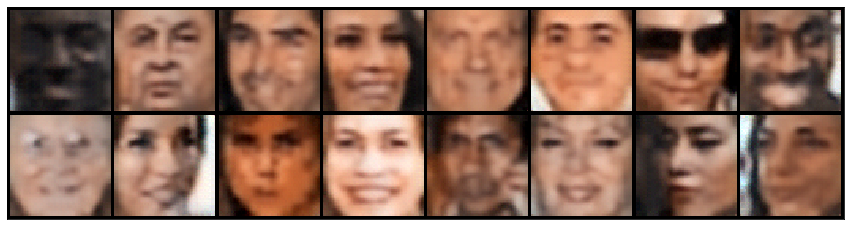

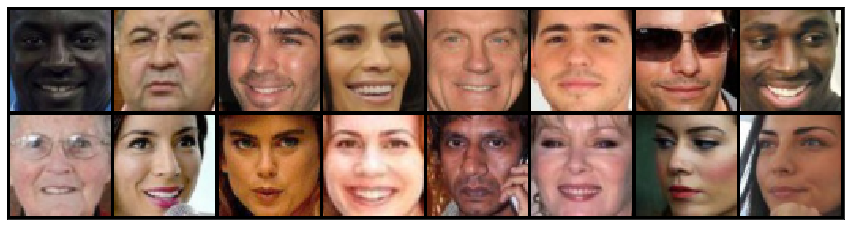

KeyboardInterrupt: 

In [98]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in range(num_training_updates):
    data = next(iter(train_dl))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / 0.5
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % SHOW_EVERY_N_ITERATION == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-SHOW_EVERY_N_ITERATION:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-SHOW_EVERY_N_ITERATION:]))
        print()
        
        show_batch(data_recon.cpu().detach(), samples=16, **dict(figsize=(15,15)))
        show_batch(data.cpu().detach(), samples=16, **dict(figsize=(15,15)))

## Plot Loss

In [99]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

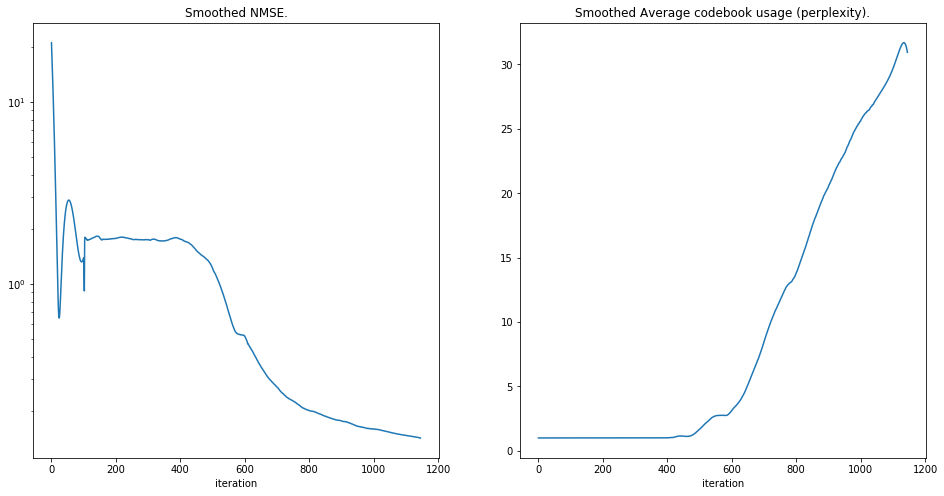

In [100]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [101]:
model.eval()
valid_originals = next(iter(valid_dl)).to(device)

In [102]:
vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


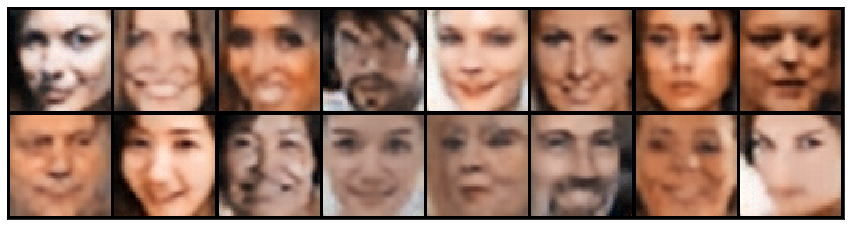

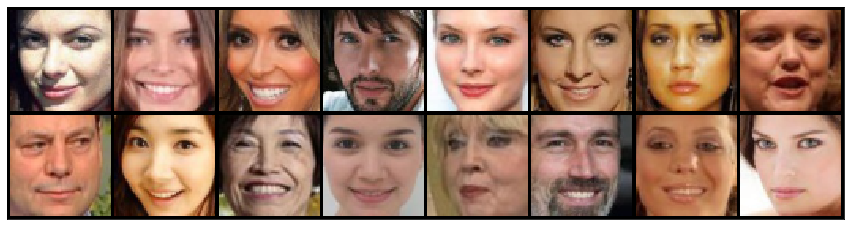

In [103]:
show_batch(valid_reconstructions.cpu().detach(), samples=16, **dict(figsize=(15,15)))
show_batch(valid_originals.cpu().detach(), samples=16, **dict(figsize=(15,15)))

## View Embedding

### Get Quantized Vectors

In [104]:
quantized_vectors = model._vq_vae._embedding.weight.data.cpu()

### Add Vectors to Projector (using SummaryWriter)

In [105]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

writer.add_embedding(quantized_vectors)
writer.close()

### Run Tensorboard

Use ```%tensorboard --host=<your_host> --port <your_port> --logdir=runs``` for Custom Host and Port 

In [106]:
%tensorboard --logdir=runs